# RPN
## Reference
* [Faster R-CNN: Towards Real-Time Object
Detection with Region Proposal Networks](https://arxiv.org/pdf/1506.01497.pdf)
* [Dive into Deep Learning](https://d2l.ai/chapter_computer-vision/anchor.html)

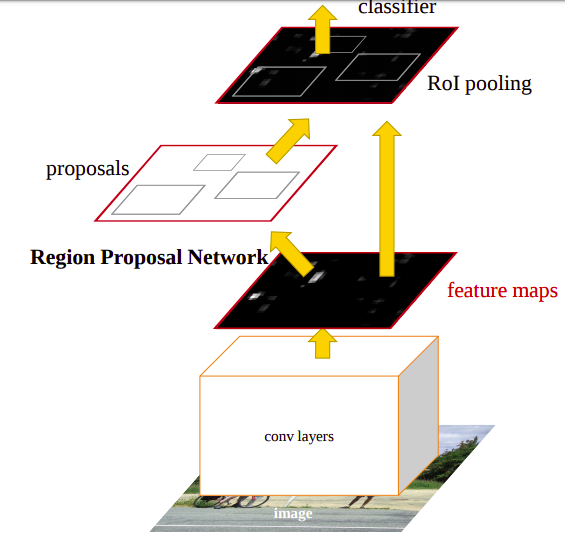

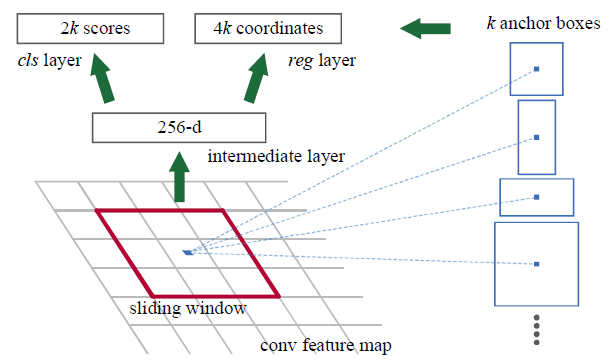

## What RPN Does
1. Generating anchor points on feature map
2. Generating anchor box (it requires Scale and Aspect ratio)
3. Calculating IoU
4. NMS

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow import keras
from keras import layers, models

In [ ]:
def idnetity_block(input_tensor, n_filter: list):
  F1, F2, F3 = n_filter
  # 1x1 conv layer
  x = layers.BatchNormalization()(input_tensor)
  x = layers.ReLU()(x)
  x = layers.Conv2D(filters=F1, kernel_size=(1, 1), strides=1, padding='valid')(x)

  # 3x3 conv layer
  x = layers.BatchNormalization()(x)
  x = layers.ReLU()(x)
  x = layers.Conv2D(filters=F2, kernel_size=(3, 3), strides=1, padding='same')(x)

  # 1x1 conv layer
  x = layers.BatchNormalization()(x)
  x = layers.ReLU()(x)
  x = layers.Conv2D(filters=F3, kernel_size=(1, 1), strides=1, padding='valid')(x)

  # shortcut connection
  x = layers.add([x, input_tensor])
  return x

In [ ]:
def conv_block(input_tensor, n_filter: list):
  F1, F2, F3 = n_filter
  # 1x1 conv layer
  x = layers.BatchNormalization()(input_tensor)
  x = layers.ReLU()(x)
  x = layers.Conv2D(filters=F1, kernel_size=(1, 1), strides=2, padding='valid')(x)

  # 3x3 conv layer
  x = layers.BatchNormalization()(x)
  x = layers.ReLU()(x)
  x = layers.Conv2D(filters=F2, kernel_size=(3, 3), strides=1, padding='same')(x)

  # 1x1 conv layer
  x = layers.BatchNormalization()(x)
  x = layers.ReLU()(x)
  x = layers.Conv2D(filters=F3, kernel_size=(1, 1), strides=1, padding='valid')(x)

  # shortcut connection
  skip = layers.Conv2D(filters=F3, kernel_size=(1, 1), strides=2, padding='valid')(input_tensor)
  x = layers.add([x, skip])

  return x

In [ ]:
def backbone(x):
  # 1st stage
  x = layers.ZeroPadding2D(padding=(3, 3))(X)
  x = layers.Conv2D(filters=64, kernel_size=(7, 7), strides=(2, 2), padding='valid')(x)

  # 2nd stage
  x = layers.MaxPool2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x) # (56, 56, 64)
  x = conv_block(x, [64, 64, 256])
  x = idnetity_block(x, [64, 64, 256])
  x = idnetity_block(x, [64, 64, 256])

  # 3rd stage
  x = conv_block(x, [128, 128, 512])
  x = idnetity_block(x, [128, 128, 512])
  x = idnetity_block(x, [128, 128, 512])
  x = idnetity_block(x, [128, 128, 512])

  # 4th stage
  x = conv_block(x, [256, 256, 1024])
  for i in range(22):
    x = idnetity_block(x, [256, 256, 1024])

  # 5th stage
  x = conv_block(C4, [512, 512, 2048])
  x = idnetity_block(x, [512, 512, 2048])
  x = idnetity_block(x, [512, 512, 2048])

  return x

In [ ]:
def _anchor_generator(input_size:list, feature_map_size:list, subsamples:list):
    H, W = input_size
    h, w = feature_map_size
    subsample_h, subsample_w = subsamples
    
    hs = np.arange(subsample_h//2, H, subsample_h)
    ws = np.arange(subsample_w//2, W, subsample_w)
    
    return np.array(np.meshgrid(hs,  ws)).T.reshape(-1, 2)

def _anchor_box_generator(input_size, feature_map_size, ratios:list=[0.5, 1, 2], scales:list=[1, 2, 3]):
    _, H, W, _ = input_size
    _, h, w, _ = feature_map_size
    subsample_h = H / h
    subsample_w = W / w
    anchors = _anchor_generator([H, W], [h, w], [subsample_h, subsample_w])
    anchor_box = np.zeros((h * w * len(ratios) * len(scales), 4))
    idx = 0
    for anchor in anchors:
        ctr_x, ctr_y = anchor
        for scale in scales:
            for ratio in ratios:
                h = subsample_h * scale * np.sqrt(ratio)
                w = subsample_w * scale * np.sqrt(1 / ratio)
                
                anchor_box[idx,0] = ctr_x - w * 0.5
                anchor_box[idx,1] = ctr_y - h * 0.5
                anchor_box[idx,2] = ctr_x + w * 0.5
                anchor_box[idx,3] = ctr_y + h * 0.5
                
                idx += 1
                
    valid_idx = np.where((anchor_box[:,0] > 0) & 
                          (anchor_box[:,1] > 0) & 
                          (anchor_box[:,2] <= W) & 
                          (anchor_box[:,3] <= H))[0]
    
    anchor_label = np.empty((len(anchor_box),))
    anchor_label.fill(-1)
    
    return [anchor_box, anchor_label, valid_idx]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


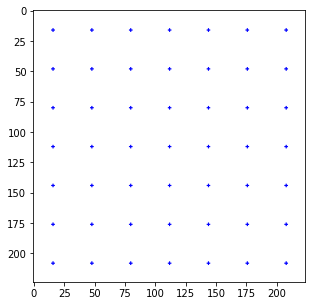

In [ ]:
input_size = (1, 224, 224, 3)
feature_map_size = (1, 7, 7, 3)
img = np.empty(shape=input_size[1:])
img.fill(255)
plt.figure(figsize=(5, 5))
anchors = _anchor_generator(input_size[1:3], feature_map_size[1:3], [224//7, 224//7])
for anchor in anchors:
  cv2.circle(img, (anchor[0], anchor[1]), radius=1, color=(0, 0, 255), thickness=-1)
plt.imshow(img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


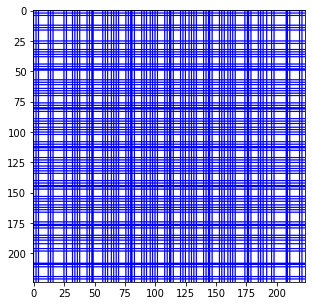

In [ ]:
anchor_box, _, _ = _anchor_box_generator(input_size, feature_map_size)
img = np.empty(shape=input_size[1:])
img.fill(255)
plt.figure(figsize=(5, 5))
for box in anchor_box:
  cv2.rectangle(img, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), color=(0, 0, 255), thickness=1)
plt.imshow(img)

In [ ]:
def iou(box1, box2):
    x11, y11, x12, y12 = box1
    x21, y21, x22, y22 = box2
    
    x1 = max(x11, x21)
    y1 = max(y11, y21)
    x2 = min(x12, x22)
    y2 = min(y12, y22)
    
    if x1 < x2 and y1 < y2:
        overlap = (x2 - x1) * (y2 - y1)
    else:
        return 0
    
    box1_area = (x12 - x11) * (y12 - y11)
    box2_area = (x22 - x21) * (y22 - y21)
    union = box1_area + box2_area - overlap

    return overlap / union

def iou_list_generator(valid_box, gt_bbox):
    iou_list = np.zeros((len(valid_box), len(gt_bbox)))
    for gt_idx, gt in enumerate(gt_bbox):
        for valid_idx, bbox in enumerate(valid_box):
            iou_list[valid_idx, gt_idx] = iou(gt, bbox)
            
    return iou_list

def best_iou(gt_bbox, valid_box):
    iou_list = iou_list_generator(valid_box, gt_bbox)
    argmax_ious = iou_list.argmax(axis=1)
    max_ious = iou_list[np.arange(len(valid_box)), argmax_ious]
    
    return [max_ious, argmax_ious]

def iou_threshold(max_ious, anchor_label, pos_threshold:float=0.7, neg_threshold:float=0.3):
    anchor_label[max_ious >= pos_threshold] = 1
    anchor_label[max_ious < neg_threshold] = 0
    return anchor_label

IoU: 0


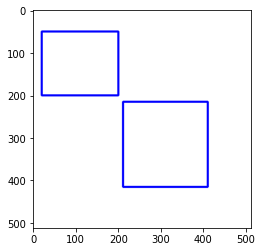

In [ ]:
box1 = [200, 200, 20, 50]
box2 = [410, 415, 211, 215]
boxes = [box1, box2]
img_ = np.zeros(shape=(512, 512, 3),dtype=np.uint8)
img_.fill(255)
for i, bbox in enumerate(boxes):
    cv2.rectangle(img_, (bbox[0], bbox[1]), (bbox[2], bbox[3]), color=(0, 0, 255), thickness=3)
    
plt.imshow(img_)
print(f"IoU: {iou(box1, box2)}")

IoU: 0


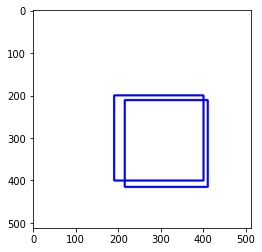

In [ ]:
box1 = [400, 400, 190, 200]
box2 = [410, 415, 215, 211]
boxes = [box1, box2]
img_ = np.zeros(shape=(512, 512, 3),dtype=np.uint8)
img_.fill(255)
for i, bbox in enumerate(boxes):
    cv2.rectangle(img_, (bbox[0], bbox[1]), (bbox[2], bbox[3]), color=(0, 0, 255), thickness=3)
    
plt.imshow(img_)
print(f"IoU: {iou(box1, box2)}")

In [ ]:
def offset_label_generator(valid_idx, valid_anchor_label, anchor_label, num_sample:int=256, pos_ratio:float=0.5):
    num_foreground = int(num_sample * pos_ratio)
    num_background = num_sample - num_foreground
    foreground_idx = np.where(anchor_label == 1)[0]
    background_idx = np.where(anchor_label == 0)[0]
    
    if len(foreground_idx) > num_foreground:
        ignore = foreground_idx[num_foreground:]
        anchor_label[ignore] = -1
    elif len(foreground_idx) < num_foreground:
        diff = num_foreground - len(foreground_idx)
        num_background += diff
        
    if len(background_idx) > num_background:
        ignore = background_idx[num_background:]
        anchor_label[ignore] = -1
        
    out_label = np.empty(len(anchor_label), dtype=np.float32)
    out_label.fill(-1)
    out_label[valid_idx] = valid_anchor_label
    out_label = np.expand_dims(out_label, 0)
    out_label = np.expand_dims(out_label, -1)
    
    return out_label

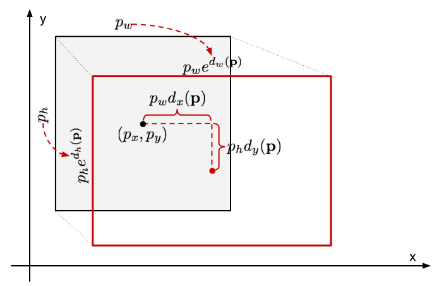

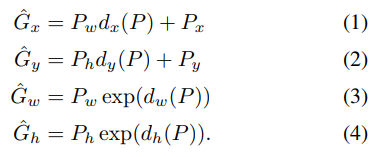

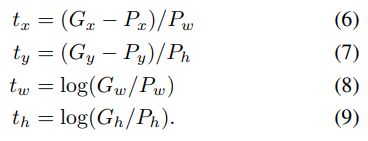

In [ ]:
def to_center(box_list):
    height = box_list[:,3] - box_list[:,1]
    width = box_list[:,2] - box_list[:,0]
    ctr_x = box_list[:,0] + height * 0.5
    ctr_y = box_list[:,1] + width * 0.5
    
    return [ctr_x, ctr_y, height, width]

def delta_calculator(gt_box, valid_box):
    valid_x, valid_y, valid_h, valid_w = to_center(valid_box)
    gt_x, gt_y, gt_h, gt_w = to_center(gt_box)
    eps = np.finfo(valid_w.dtype).eps
    height = np.maximum(eps, valid_h)
    width = np.maximum(eps, valid_w)
    
    dx = (gt_x - valid_x) / width
    dy = (gt_y - valid_y) / height
    dh = np.log((gt_h / height).astype(np.float32))
    dw = np.log((gt_w / width).astype(np.float32))
    
    return [dx, dy, dh, dw]

def offset_box_delta_generator(anchor_box, valid_idx, anchor_gt):
    offset_delta = np.empty(anchor_box.shape, dtype=np.float32)
    offset_delta .fill(0)
    dx, dy, dh, dw = delta_calculator(anchor_gt, valid_anchor_box)
    offset_delta[valid_idx] = np.column_stack((dx, dy, dh, dw))
    offset_delta = np.expand_dims(offset_delta, axis=0)
    
    return offset_delta

In [ ]:
anchor_box, anchor_label, valid_idx = _anchor_box_generator([1, 224, 224, 3], [1, 7, 7, 3])
valid_anchor_box = anchor_box[valid_idx]
valid_anchor_idx = anchor_label[valid_idx]

gt_bbox = np.asarray([[25, 25, 75, 125], [100, 150, 200, 200]], dtype=np.ndarray)
gt_label = np.array([1, 3])
valid_ious, argmax_ious = best_iou(gt_bbox, valid_anchor_box)
anchor_box_to_gt = gt_bbox[argmax_ious]
valid_label_threshold = iou_threshold(valid_ious, valid_idx)
offset_label = offset_label_generator(valid_idx, valid_label_threshold, anchor_label)
offset_delta = offset_box_delta_generator(anchor_box, valid_idx, anchor_box_to_gt)

In [ ]:
offset_label.shape, offset_delta.shape

((1, 441, 1), (1, 441, 4))

In [ ]:
def rpn(input_tensor):
  '''RPN layer model
  
  Args
    input_tensor: tf.Tensor(batch, H, W, C) from backbone network.

  Return
    object score: (int) 0 if there is not object else 1
    bounding box score: (float) [0, 1]
  '''
  x = layers.Conv2D(kernel=256, kernel_size=3, padding='valid', activaion='relu')(input_tensor)
  cls = layers.Conv2D(kernel=num_anchor, kernel_size=1, padding='valid', activaion='sigmoid')(x)
  reg = layers.Conv2D(kernel=num_anchor*4, kernel_size=1, padding='valid', activaion='linear')(x)
  return cls, reg

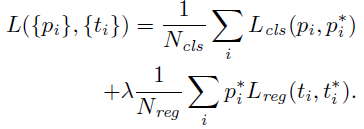

Regression loss is smoothed L1 function defined in [Fast R-CNN](https://arxiv.org/pdf/1504.08083.pdf)

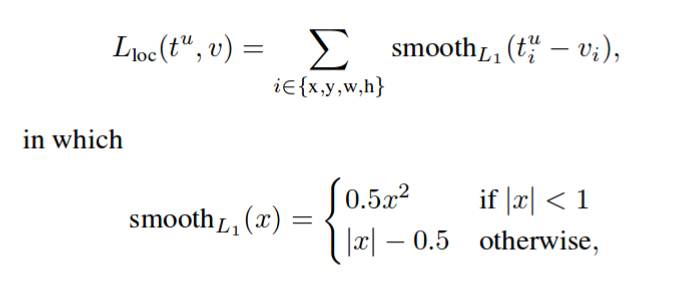

In [ ]:
def smooth_func(x):
  x = tf.abs(x)
  compare = tf.ones((num_anchor, x))
  out = tf.where(tf.less(x, compare), tf.pow(x, 2)*0.5, x-0.5)
  return out

def smooth_L1(preds, truth):
  diff = truth - preds
  out = tf.map_fn(smooth_func, diff)
  return out

def rpn_loss(cls_preds, cls_truth, bbox_preds, bbox_truth):
  Lambda = 1e+3
  cls_loss = (cls_truth * tf.math.log(cls_preds) - (1 - cls_truth) * tf.math.log(1 - cls_preds)) / num_anchor
  reg_loss = smooth_L1(bbox_preds, bbox_truth)
  out = tf.add(cls_loss, reg_loss * Lambda)
  return out

In [ ]:
import numpy as np